<a href="https://colab.research.google.com/github/Big-Stanz/NLP-Machine-Translation/blob/main/Computer_Science_Project_Sentiment_AnalysisGRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [7]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Setting toolkit folder as working directory

%cd /content/drive/My Drive/1_LiveProjects/Project8_SentimentAnalysis_with_NeuralNetwork
! ls

/content/drive/My Drive/Project8_SentimentAnalysis_with_NeuralNetwork
a1_IMDB_Dataset.csv	    b_SentimentAnalysis_with_NeuralNetwork.ipynb
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.856.h5
a3_IMDb_Unseen_Reviews.csv  c2_IMDb_Unseen_Predictions.csv


In [10]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
#from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [13]:
# Importing IMDb Movie Reviews dataset

#movie_reviews = pd.read_csv("/content/a1_IMDB_Dataset.csv")
!pip install pandas
import csv

with open("/content/a1_IMDB_Dataset.csv", "r") as file:
    reader = csv.reader(file)
    lines = list(reader)

for i, line in enumerate(lines):
    if i == 10274:
        line[-1] = line[-1] + '"'

with open("/content/a1_IMDB_Dataset_fixed.csv", "w") as file:
    writer = csv.writer(file)
    writer.writerows(lines)

In [14]:
movie_reviews = pd.read_csv("/content/a1_IMDB_Dataset_fixed.csv")

In [15]:
# Dataset exploration

movie_reviews.shape

(24515, 2)

In [16]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
# Checking for missing values

movie_reviews.isnull().values.any()

True

<Axes: xlabel='sentiment', ylabel='count'>

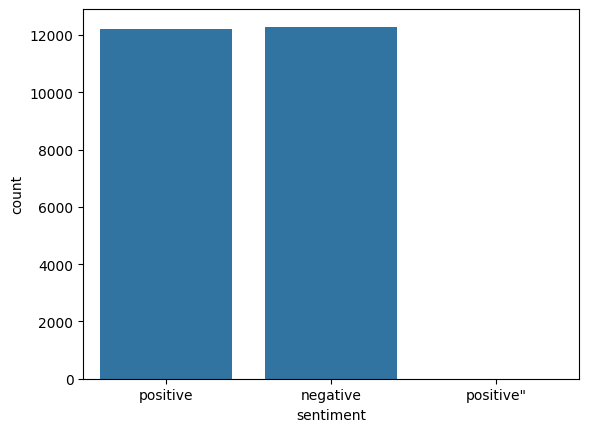

In [18]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [71]:
movie_reviews["review"][3]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [20]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [23]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [24]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [25]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [26]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [27]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

import keras.preprocessing.text as kpt
word_tokenizer =kpt.Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [28]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

68460

In [29]:
# Padding all reviews to fixed length 100

maxlen = 100



import keras.preprocessing.sequence

X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

'''X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)'''

"X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)\nX_test = pad_sequences(X_test, padding='post', maxlen=maxlen)"

In [30]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [31]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(53647, 100)

# Model Training with:

## Simple Neural Network

In [32]:
# Neural Network architecture
import keras.models
import keras.layers
snn_model = keras.models.Sequential()
embedding_layer = keras.layers.Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

snn_model.add(embedding_layer)

snn_model.add(keras.layers.Flatten())
snn_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [33]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6846000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 6856001 (26.15 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 6846000 (26.12 MB)
_________________________________________________________________
None


In [35]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
123/123 [==============================] - 1s 10ms/step - loss: 0.2948 - acc: 0.8864 - val_loss: 0.5752 - val_acc: 0.7415
Epoch 2/20
123/123 [==============================] - 1s 9ms/step - loss: 0.2757 - acc: 0.8978 - val_loss: 0.5860 - val_acc: 0.7380
Epoch 3/20
123/123 [==============================] - 1s 9ms/step - loss: 0.2626 - acc: 0.9040 - val_loss: 0.5993 - val_acc: 0.7346
Epoch 4/20
123/123 [==============================] - 1s 11ms/step - loss: 0.2512 - acc: 0.9106 - val_loss: 0.6128 - val_acc: 0.7336
Epoch 5/20
123/123 [==============================] - 1s 9ms/step - loss: 0.2415 - acc: 0.9134 - val_loss: 0.6264 - val_acc: 0.7321
Epoch 6/20
123/123 [==============================] - 1s 7ms/step - loss: 0.2304 - acc: 0.9224 - val_loss: 0.6390 - val_acc: 0.7321
Epoch 7/20
123/123 [==============================] - 1s 6ms/step - loss: 0.2225 - acc: 0.9237 - val_loss: 0.6520 - val_acc: 0.7318
Epoch 8/20
123/123 [==============================] - 1s 5ms/step - loss: 

In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

84/84 [==============================] - 0s 1ms/step - loss: 0.5669 - acc: 0.7273


In [40]:
# Model Performance
from sklearn import metrics
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

NameError: name 'score' is not defined

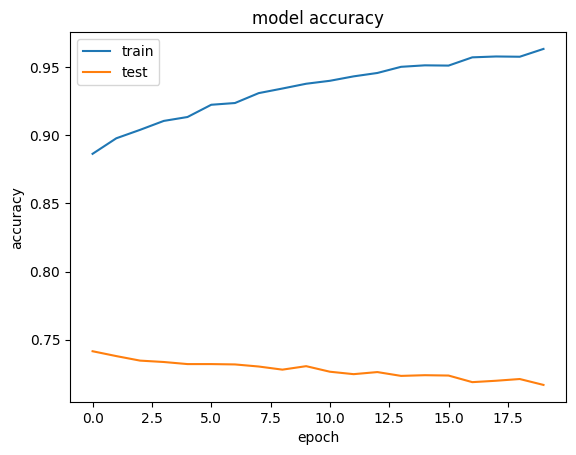

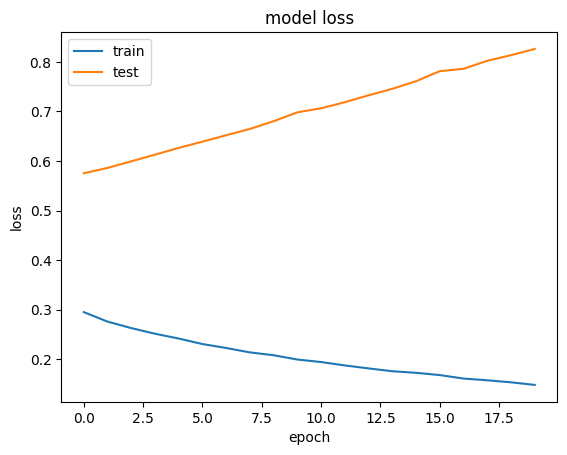

In [41]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [42]:
from keras.layers import Conv1D

In [43]:
# Neural Network architecture

import keras.layers
import keras.models
from keras.layers import Embedding

#import keras.layers.embeddings
cnn_model = keras.models.Sequential()

embedding_layer = keras.layers.Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(keras.layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [44]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6846000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6910257 (26.36 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 6846000 (26.12 MB)
_________________________________________________________________
None


In [45]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
123/123 [==============================] - 14s 107ms/step - loss: 0.5391 - acc: 0.7276 - val_loss: 0.4486 - val_acc: 0.8055
Epoch 2/6
123/123 [==============================] - 13s 106ms/step - loss: 0.3765 - acc: 0.8430 - val_loss: 0.4125 - val_acc: 0.8109
Epoch 3/6
123/123 [==============================] - 14s 111ms/step - loss: 0.3091 - acc: 0.8765 - val_loss: 0.3876 - val_acc: 0.8267
Epoch 4/6
123/123 [==============================] - 11s 89ms/step - loss: 0.2620 - acc: 0.9041 - val_loss: 0.3725 - val_acc: 0.8358
Epoch 5/6
123/123 [==============================] - 12s 94ms/step - loss: 0.2150 - acc: 0.9307 - val_loss: 0.3772 - val_acc: 0.8320
Epoch 6/6
123/123 [==============================] - 13s 105ms/step - loss: 0.1757 - acc: 0.9537 - val_loss: 0.3703 - val_acc: 0.8402


In [46]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

154/154 [==============================] - 2s 10ms/step - loss: 0.3780 - acc: 0.8381


In [47]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37796923518180847
Test Accuracy: 0.838058352470398


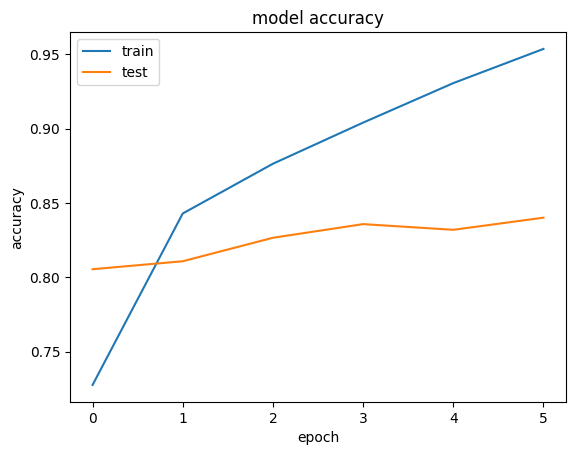

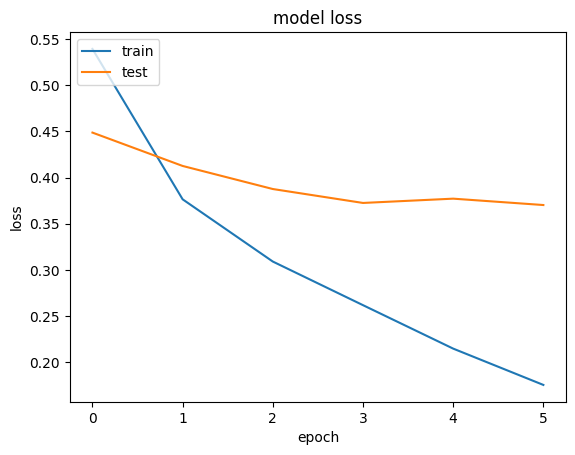

In [48]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [49]:
from keras.layers import LSTM

In [50]:
# Neural Network architecture
import keras
from keras.layers import Dense
lstm_model = keras.Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [51]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          6846000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6963377 (26.56 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 6846000 (26.12 MB)
_________________________________________________________________
None


In [56]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
123/123 [==============================] - 44s 352ms/step - loss: 0.3205 - acc: 0.8683 - val_loss: 0.3636 - val_acc: 0.8376
Epoch 2/10
123/123 [==============================] - 45s 366ms/step - loss: 0.2978 - acc: 0.8744 - val_loss: 0.3641 - val_acc: 0.8468
Epoch 3/10
123/123 [==============================] - 44s 358ms/step - loss: 0.2739 - acc: 0.8895 - val_loss: 0.3888 - val_acc: 0.8399
Epoch 4/10
123/123 [==============================] - 41s 334ms/step - loss: 0.2717 - acc: 0.8886 - val_loss: 0.3671 - val_acc: 0.8437
Epoch 5/10
123/123 [==============================] - 44s 357ms/step - loss: 0.2458 - acc: 0.9029 - val_loss: 0.3874 - val_acc: 0.8455
Epoch 6/10
123/123 [==============================] - 43s 353ms/step - loss: 0.2107 - acc: 0.9200 - val_loss: 0.4108 - val_acc: 0.8343
Epoch 7/10
123/123 [==============================] - 41s 333ms/step - loss: 0.1941 - acc: 0.9275 - val_loss: 0.4208 - val_acc: 0.8432
Epoch 8/10
123/123 [==============================] - 4

In [57]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

154/154 [==============================] - 10s 68ms/step - loss: 0.5070 - acc: 0.8438


In [58]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5069571137428284
Test Accuracy: 0.8437691330909729


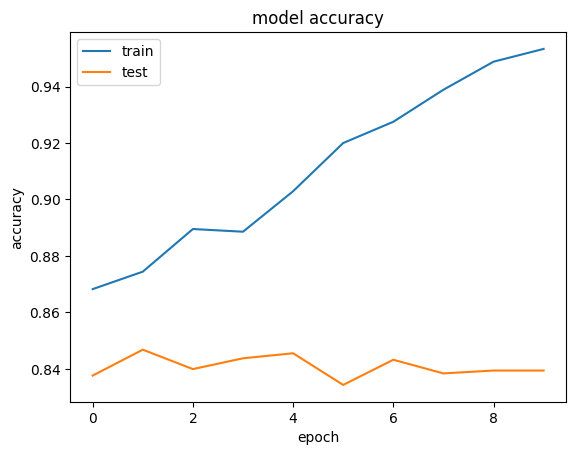

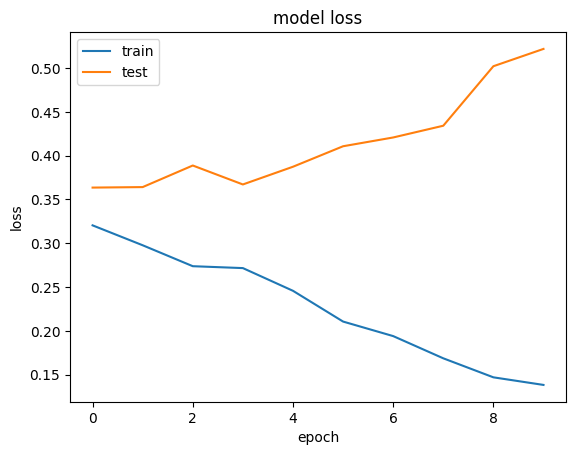

In [59]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [60]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
lstm_model.save('my_model.keras')

# Making Predictions on Live IMDb data

In [64]:
!ls # lists files in working directory

 a1_IMDB_Dataset.csv	     a3_IMDb_Unseen_Reviews.csv   my_model.keras
 a1_IMDB_Dataset_fixed.csv   c1_lstm_model_acc_0.844.h5   sample_data
 a2_glove.6B.100d.txt	    'Google Chrome.app.zip'


In [ ]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [65]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [72]:
sample_reviews['Review Text'][3]

"Had Great Potential.\nThis movie is one of the countless that have come out of Hollywood that had great potential.\n\nHowever, like so many personalities in Hollywood, it sold it's soul for a cheap finish.\n\nThere were some beautiful ideas in this movie, and it could of been great.\n\nHowever, the producers chose to go for the cheap thriller effect, instead of exploring what truly makes us human or machine. Conceived, written, and produced by idiots with now soul.\n\nDon't waste your time.\n\nThe only redeeming part of this movie was when the dweeb gets sent to the sticks, and is surprised when his smartphone tell him that there was no signal. The producers and writers of this piece of crap obviously had no signal also."

In [66]:
   # Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [67]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
from keras.preprocessing.sequence import pad_sequences
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [68]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 632ms/step


array([[0.9942796 ],
       [0.9997486 ],
       [0.01364923],
       [0.9838817 ],
       [0.9971071 ],
       [0.00271565]], dtype=float32)

In [69]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.9
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,9.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,10.0
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.0


In [70]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.9
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,9.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,10.0
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.0


In [1]:
!nltk.download('vader_lexicon')

/bin/bash: -c: line 1: syntax error near unexpected token `'vader_lexicon''
/bin/bash: -c: line 1: `nltk.download('vader_lexicon')'


In [2]:
!pip install nltk
!pip install nltk.download('vader_lexicon')
!nltk.download('vader_lexicon')


import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install nltk.download('vader_lexicon')'
/bin/bash: -c: line 1: syntax error near unexpected token `'vader_lexicon''
/bin/bash: -c: line 1: `nltk.download('vader_lexicon')'


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
sia.polarity_scores("This is very good")

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}